## Symbolic Regressor

- 최적화 문제는 고도로 비선형화되며 제약조건을 만족해야하기 때문에, 전통적 최적화 알고리즘만으로 해결하기에는 어려움이 있음.
    - ex. 초기조건 민감성, 미분가능성, 대량 메모리 요구


- 이러한 한계점을 극복을 위한 휴리스틱 알고리즘이 개발됨
    - ex. Swarm Intelligence, Tabu Search, Simulated Anealing, GA(유전알고리즘), GP(유전프로그래밍), NN(인공신경망)
    - 시행착오에 기반해 최적화 문제에 대해 비교적 예측 가능한 시간 내에 정답에 가까운 근사값을 계산할 수 있는 알고리즘


- EA(Evolutionary Algorithm)
    - GA
        - 자연선택(natural selection), 유전자(chromosome)들의 상호작용에 기반해 선택(selection), 교배(crossover), 및 돌연변이(mutation)들을 기본 연산자로 하는 최적화 알고리즘
    - GP
        - Koza [2] 에 의해 소개되었으며 유전알고리즘과 유사하지만, 유전자를 표현하는 장법에서 차이를 보임.
    - PGP(Parellel Genetic Programming)
        - GP를 병렬로 수행하는 알고리즘. 해집단(population)을 운용하는 EA알고리즘에서 해집단들 사이의 다양성을 높일 수 있는 장점
- ANN
    - 독립변수와 종속변수의 관계가 선형이라면, LR을 사용할 수 있다.
    - 독립변수와 종속변수의 관계가 비선형이라면, ANN도 계산할 수 있다.
        - ANN은 생성된 모델 자체를 이해하는 과정에 어려움 있고, SR(Symbolic Regression)은 함수 f 자체를 생성하기 때문에 해석이 비교적 용이하다.






- References
    - Chansoo Kim, et al.(2020), Symolic regression based on parallel Genetic Programming (https://koreascience.kr/article/JAKO202008540580194.pdf)
    - [2] J.R. Koza (1992), Genetic Programming: On the Programming of Computers by Means of Natural Selection, MIT Press, Cambridge, MA.

In [1]:
%matplotlib inline
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import graphviz

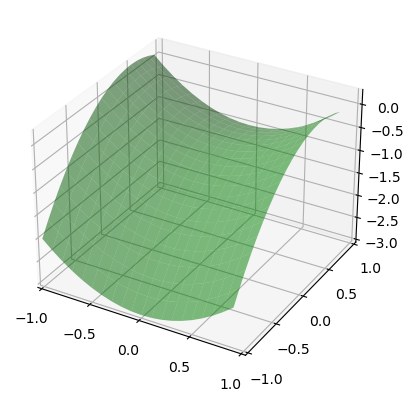

In [2]:
# Ground truth
x0 = np.arange(-1, 1, .1)
x1 = np.arange(-1, 1, .1)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.arange(-1, 1.01, .5))
ax.set_yticks(np.arange(-1, 1.01, .5))
# X, Y, Z
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, color='green', alpha=0.5)
plt.show()

- 예시 데이터
    - $y = X_{0}^{2} - X_{1}^{2} + X_{1} -1 $

In [3]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

- 데이터에 Symbolic Regressor를 다뤄보자. 데이터가 작기 때문에 데이터에 꽤 큰 해집단(Population)을 설정해도, 학습시간은 빠를 것이다. 
    - 20세대까지 진화하고, 오차가 0.01이 될때까지 학습
    - 실험하는 Equation은 기본적인 사칙연산(+-*/)을 사용
    - OOB의 오차를 관찰하기 위해 mutation과 subsampling을 수행한다.
    - 실제 해는 간단한 방정식으로 구성되어 있음을 알기 때문에, 해를 작게 유지하기 위해 parisimony coefficient를 설정한다.


- `p_crossover`
    - The probability of performing crossover on a tournament winner. Crossover takes the winner of a tournament and selects a random subtree from it to be replaced. A second tournament is performed to find a donor. The donor also has a subtree selected at random and this is inserted into the original parent to form an offspring in the next generation.
- `p_subtree_mutation`
    - The probability of performing subtree mutation on a tournament winner. Subtree mutation takes the winner of a tournament and selects a random subtree from it to be replaced. A donor subtree is generated at random and this is inserted into the original parent to form an offspring in the next generation.
- `p_hoist_mutation`
    - The probability of performing hoist mutation on a tournament winner. Hoist mutation takes the winner of a tournament and selects a random subtree from it. A random subtree of that subtree is then selected and this is ‘hoisted’ into the original subtrees location to form an offspring in the next generation. This method helps to control bloat.
- `p_point_mutation`
    - The probability of performing point mutation on a tournament winner. Point mutation takes the winner of a tournament and selects random nodes from it to be replaced. Terminals are replaced by other terminals and functions are replaced by other functions that require the same number of arguments as the original node. The resulting tree forms an offspring in the next generation.
- `max_samples`
    - The fraction of samples to draw from X to evaluate each program on.
- `parsimony_coefficient`(default=0.001 float or "auto")
    - This constant penalizes large programs by adjusting their fitness to be less favorable for selection. Larger values penalize the program more which can control the phenomenon known as ‘bloat’. Bloat is when evolution is increasing the size of programs without a significant increase in fitness, which is costly for computation time and makes for a less understandable final result. This parameter may need to be tuned over successive runs.

    - If “auto” the parsimony coefficient is recalculated for each generation using c = Cov(l,f)/Var( l), where Cov(l,f) is the covariance between program size l and program fitness f in the population, and Var(l) is the variance of program sizes.

In [4]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764     37.20s
   1     9.97          1.70233        5         0.320202         0.624787     19.63s
   2     7.72          1.94456       11         0.239537         0.533148     17.80s
   3     5.41         0.990157        7         0.235676         0.719906     16.84s
   4     4.66         0.894443       11         0.103946         0.103946     14.83s
   5     5.41         0.940242       11         0.060802         0.060802     13.88s
   6     6.78          1.09536       11      0.000781474      0.000781474     13.44s


SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [5]:
print(est_gp._program)

sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


- 0.01보다 오차가 나아짐에 따라 evolution process가 일찍 멈춘 것을 확인할 수 있다.
    - 또한 프로그램의 평균 길이의 변동을 살펴보면, parsimony coefficient가 적절했음을 확인할 수 있다.
        - 대형 프로그램의 fitness에 패널티는 주어, bloat 현상을 제어하하는 파라미터. bloat은 fitness의 증가 없이 프로그램의 크기를 증가하는 현상으로 계산 비용이 커지고 이해하기 어려운 결과를 만듬.
        - auto로 설정하는 경우, 변수의 분산과 공분산을 활용.
        - cf. bloat https://gplearn.readthedocs.io/en/stable/intro.html#bloat
    - 유전프로그래밍으로 찾은 해를, 풀어보면 우리가 가정한 수식과 거의 일치함을 알 수 있다.
        - $y = (-0.999 + X_1) - ((X_1 - X_0) \times (X_0 + X_1))$
        - $y = X_1 - 0.999 - (X_1 X_0 + X_1^{2} - X_0^{2} - X_0 X_1)$
        - $y = X_0^{2} - X_1^{2} + X_1 - 0.999$
        

- 다른 비선형 모형과 살펴보면, Symbolic regressor는 smooth하고 트리 계열 모형들은 blocky한 것을 확인 할 수 있다.
    - 또한, OOB에서의 성능이 트리계열보다 좋다.


In [6]:
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor(n_estimators=10)
est_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

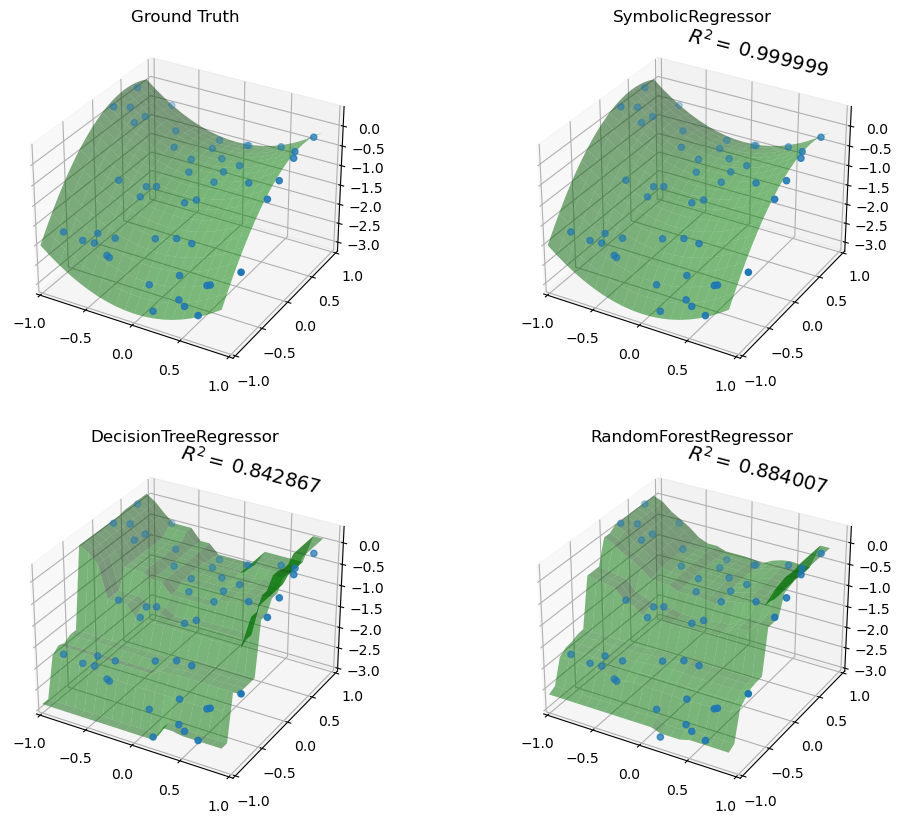

In [7]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(-1, 1.01, .5))
    ax.set_yticks(np.arange(-1, 1.01, .5))
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)

plt.show()


- SymbolicRegressor가 찾은 프로그램을 조사해보자.




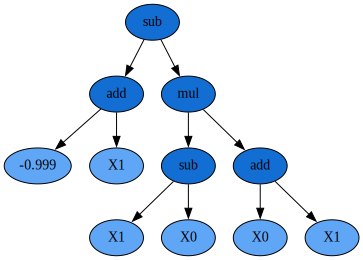

In [8]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1_child', format='png', cleanup=True)
display(graph)

- 부모 노드가 어떤 것인지 확인할 수 있다.
    - 아래 딕셔너리는 현재 결과에서 evolution operation이 어떻게 수행되었는지 알려준다.
    - cf. https://gplearn.readthedocs.io/en/stable/intro.html#evolution


In [9]:
print(est_gp._program.parents)

{'method': 'Crossover', 'parent_idx': 1555, 'parent_nodes': range(1, 4), 'donor_idx': 78, 'donor_nodes': []}


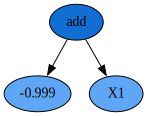

In [10]:
idx = est_gp._program.parents['donor_idx']
fade_nodes = est_gp._program.parents['donor_nodes']
dot_data = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = graphviz.Source(dot_data)
display(graph)

## Symbolic Transformer


- 비선형 feature를 자동으로 생성하는 Symbolic Transformer를 살펴보자.

- 300개의 데이터셋을 학습데이터로 200개(142개임)를 평가데이터 셋으로 릿지회귀 해보자.
    - $R^{2}$는 0.43이 나온다.

In [11]:
from gplearn.genetic import SymbolicTransformer
from sklearn.utils import check_random_state
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
import numpy as np

In [12]:
rng = check_random_state(0)
diabetes = load_diabetes()
perm = rng.permutation(diabetes.target.size)
diabetes.data = diabetes.data[perm]
diabetes.target = diabetes.target[perm]


In [13]:
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [14]:
est = Ridge()
est.fit(diabetes.data[:300, :], diabetes.target[:300])
print(est.score(diabetes.data[300:, :], diabetes.target[300:]))


0.434057421057894


- 먼저 symbolic transformer를 학습해보자.
    - 해집합(population)을 2000으로 놓고 세대는 20세대로 놓는다.
    - 이 중 가장 좋은 100개의 변수(hall_of_fame) 중에, 가장 상관성이 적은 10개의 새로운 변수로 선택한다.
    - bloat를 조절하기 위한 parsimony_coefficient 파라미터만 설정하고 다른 진화와 관련된 파라미터는 기본설정으로 놓는다.
    - 선형모형을 사용하기 때문에 피어슨 상관성을 사용하도록 한다.
        - 트리 기반의 모형을 사용하는 경우, `metric='spearman'`으로 설정하는 것이 좋을 수 있다.


In [15]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)
gp.fit(diabetes.data[:300, :], diabetes.target[:300])


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.37         0.126618        5         0.612827             0.68     16.87s
   1     6.63         0.344375        3         0.659086         0.451797      7.81s
   2     5.36         0.473731        3         0.669019         0.321485      5.93s
   3     4.74         0.587613        3         0.673354          0.31249      5.69s
   4     4.39         0.597151       13         0.675282          0.49482      5.47s
   5     4.31         0.611995       15         0.686134         0.148203      5.79s
   6     4.89         0.611891        9         0.685649         0.199002      4.61s
   7     6.49         0.617031        9         0.688309         0.287286      4.07s
   8     9.19         0.628618       17         0.720606          0.26362  

SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    max_samples=0.9, n_jobs=3, parsimony_coefficient=0.0005,
                    population_size=2000, random_state=0, verbose=1)

- 위에서 구한 새로운 feature와 기존 feature를 결합하는 경우, 새로운 데이터에 대한  $R^{2}$ 값이 유의미하게 커진 것을 확인할 수 있다.

In [16]:
gp_features = gp.transform(diabetes.data)
new_diabetes = np.hstack((diabetes.data, gp_features))


In [17]:
gp_features.shape

(442, 10)

In [18]:
diabetes.data.shape

(442, 10)

In [19]:
new_diabetes.shape

(442, 20)

In [20]:
est = Ridge()
est.fit(new_diabetes[:300, :], diabetes.target[:300])
print(est.score(new_diabetes[300:, :], diabetes.target[300:]))


0.5336788517320443
